## Running Lasso and Logistic regression into the compressed embeddings

In [73]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from scipy.stats import spearmanr

from sklearn import metrics
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV

import warnings
from sklearn.exceptions import ConvergenceWarning

## Functions

In [27]:
def run_lassoCV(X_train, y_train, X_val, y_val):
    # Silence the ConvergenceWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        
        model = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
        model.score(X_train, y_train)
        # Make predictions on the val set
        y_pred = model.predict(X_val)

        # Evaluate the model
        rho, _ = spearmanr(y_val, y_pred)
        r2 = metrics.r2_score(y_val, y_pred)
        num_zero_coefs = sum(model.coef_ != 0)

        print(f"R2 Score: {r2:.3f}")
        print(f"rho Score: {rho:.3f}")
        print(f"Best alpha: {model.alpha_}")
        print(f"Number of non-zero coefficients: {num_zero_coefs}")

    return model

In [ ]:
# Silence the ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    # Create and fit the model
    model = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    accuracy = metrics.accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Best C: {model.C_}")

# Assuming X_train, y_train, X_val, and y_val are defined elsewhere in your code

In [28]:
def plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val):
   
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    
    for i, split in enumerate(['train', 'val', 'test']):
        if split == 'train':
            X = X_train
            y = y_train
        elif split == 'test':
            X = X_test
            y = y_test
        else:
            X = X_val
            y = y_val
    
        y_pred = model.predict(X)
        rho, _ = spearmanr(y, y_pred)
        r2 = metrics.r2_score(y, y_pred)
    
        sns.regplot(x=y, y=y_pred, scatter_kws={'s': 5, 'alpha': 0.3}, ax=axes[i])
        axes[i].set_xlabel('True')
        axes[i].set_ylabel('Predicted')
        axes[i].set_title(f"{split} set")
        axes[i].text(0.05, 0.95, f"R2: {r2:.3f}\nRho: {rho:.3f}",
                     transform=axes[i].transAxes,
                     verticalalignment='top')
    
    
    plt.tight_layout()
    plt.show()

In [57]:
def load_data(dataset_name, compression_methd):

    if dataset_name == 'beta_lactamase':
        target_name = 'scaled_effect1'
    elif dataset_name == 'fluorescence':
        target_name = 'log_fluorescence'
    elif dataset_name == 'subcellular_localization' or dataset_name == 'subcellular_localization_2':
        target_name = 'localization'
    elif dataset_name == 'solubility':
        target_name = 'solubility'
    elif dataset_name == 'stability':
        target_name = 'stability_score'


    ## train
    metadata_train = pd.read_csv(f'data/benchmarks/{dataset_name}/{dataset_name}_train_metadata.csv')
    embed = pd.read_pickle(f'embeddings/embeddings_benchmarks/{dataset_name}_train_esm2_150M_compressed/embed_layer_30_{compression_methd}.pkl')
    embed = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed.rename(columns={'index':'ID'}, inplace=True)
    train = pd.merge(metadata_train,embed, on='ID')
    y_train = train[target_name].values
    X_train = train.iloc[:, metadata_train.shape[1]:].values
   
    ## test
    metadata_test = pd.read_csv(f'data/benchmarks/{dataset_name}/{dataset_name}_test_metadata.csv')
    embed = pd.read_pickle(f'embeddings/embeddings_benchmarks/{dataset_name}_test_esm2_150M_compressed/embed_layer_30_{compression_methd}.pkl')
    embed = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed.rename(columns={'index':'ID'}, inplace=True)
    test = pd.merge(metadata_test,embed, on='ID')
    y_test = test[target_name].values
    X_test = test.iloc[:, metadata_test.shape[1]:].values


    ## val
    metadata_valid = pd.read_csv(f'data/benchmarks/{dataset_name}/{dataset_name}_valid_metadata.csv')
    embed = pd.read_pickle(f'embeddings/embeddings_benchmarks/{dataset_name}_valid_esm2_150M_compressed/embed_layer_30_{compression_methd}.pkl')
    embed = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed.rename(columns={'index':'ID'}, inplace=True)
    val = pd.merge(metadata_valid, embed, on='ID')
    y_val = val[target_name].values
    X_val = val.iloc[:, metadata_valid.shape[1]:].values

    print('Dataset statistics')
    print(f"Train --> X:{X_train.shape}, y:{y_train.shape}\nVal  --> X:{X_val.shape}, y:{y_val.shape}\nTest --> X:{X_test.shape}, y:{y_test.shape}")
    return X_train, y_train, X_test, y_test, X_val, y_val

In [49]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('beta_lactamase', 'mean')

Dataset statistics
Train --> X:(4158, 640), y:(4158,)
Val  --> X:(520, 640), y:(520,)
Test --> X:(520, 640), y:(520,)


## Modeling Lactamase

### Mean embedding

In [50]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('beta_lactamase', 'mean')

Dataset statistics
Train --> X:(4158, 640), y:(4158,)
Val  --> X:(520, 640), y:(520,)
Test --> X:(520, 640), y:(520,)


In [51]:
model = run_lassoCV(X_train, y_train, X_val, y_val)
model

R2 Score: 0.701
rho Score: 0.795
Best alpha: 1.612921068449328e-06
Number of non-zero coefficients: 358


LassoCV(cv=5, random_state=0)

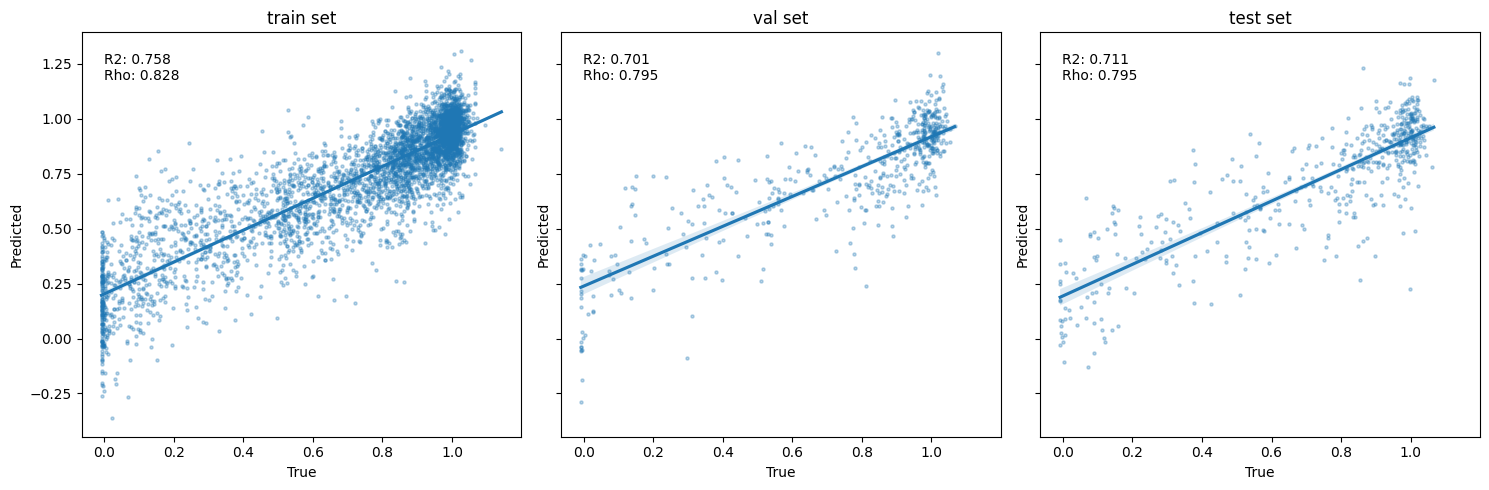

In [52]:
plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val)

## iDCT

In [53]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('beta_lactamase', 'iDCT')

Dataset statistics
Train --> X:(4158, 5120), y:(4158,)
Val  --> X:(520, 5120), y:(520,)
Test --> X:(520, 5120), y:(520,)


In [54]:
model = run_lassoCV(X_train, y_train, X_val, y_val)
model

R2 Score: 0.768
rho Score: 0.830
Best alpha: 1.8424153971938344e-05
Number of non-zero coefficients: 1257


LassoCV(cv=5, random_state=0)

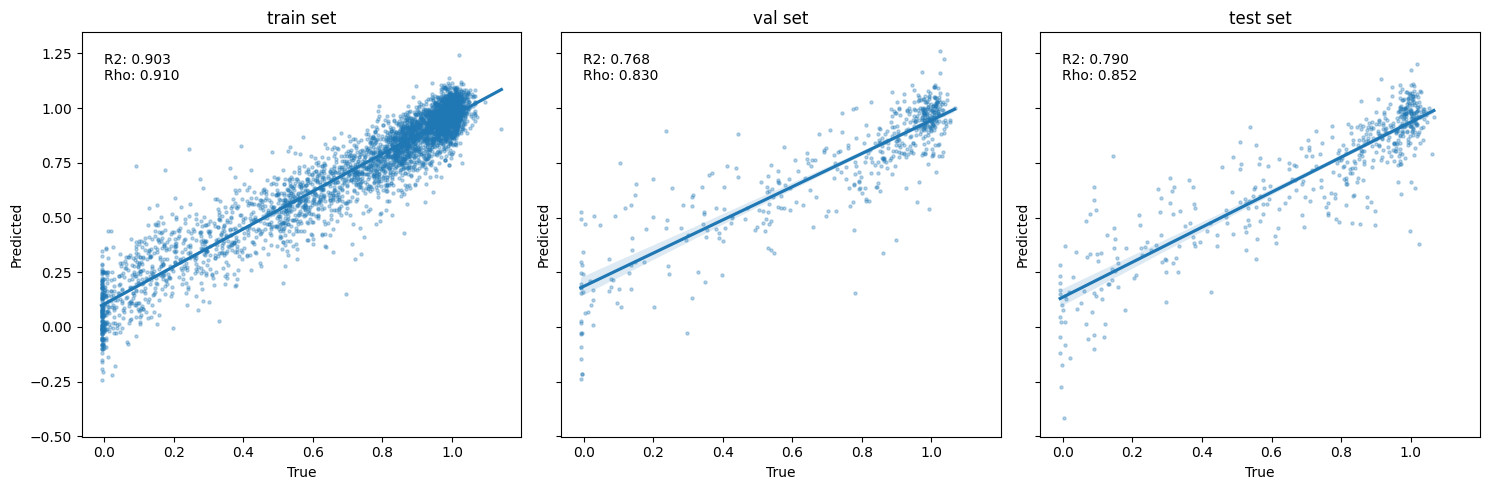

In [55]:
plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val)

## Fluorescente

In [58]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('fluorescence', 'mean')

Dataset statistics
Train --> X:(21446, 640), y:(21446,)
Val  --> X:(5362, 640), y:(5362,)
Test --> X:(27217, 640), y:(27217,)


In [59]:
model = run_lassoCV(X_train, y_train, X_val, y_val)
model

R2 Score: 0.549
rho Score: 0.618
Best alpha: 9.003593418498788e-06
Number of non-zero coefficients: 349


LassoCV(cv=5, random_state=0)

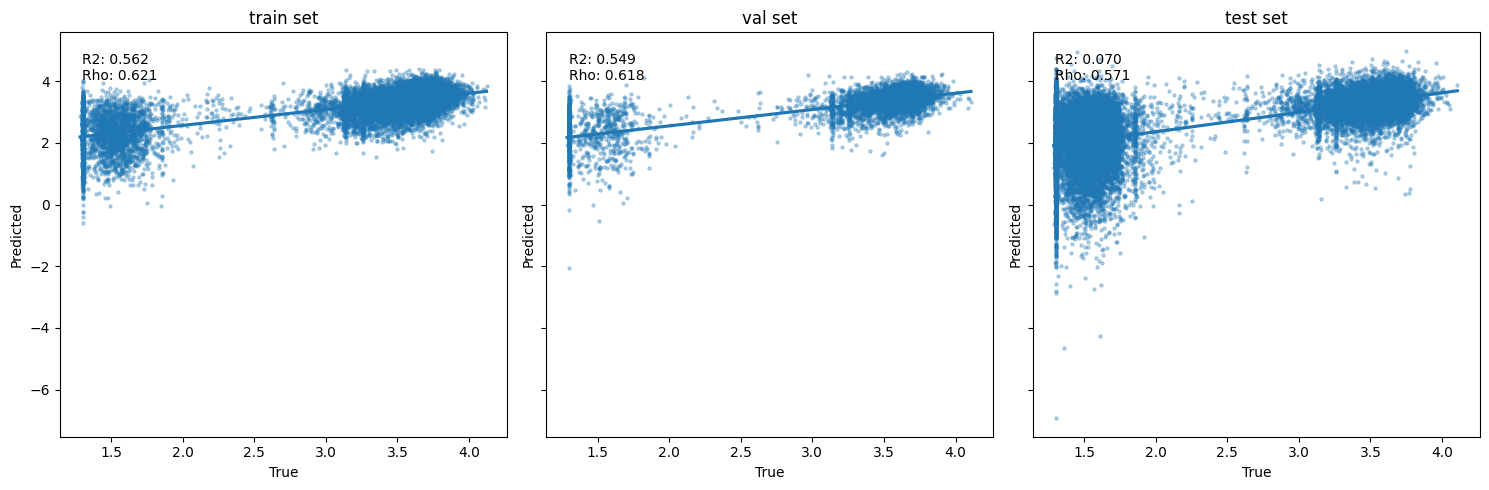

In [60]:
plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val)

### iDCT

In [61]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('fluorescence', 'iDCT')

Dataset statistics
Train --> X:(21446, 5120), y:(21446,)
Val  --> X:(5362, 5120), y:(5362,)
Test --> X:(27217, 5120), y:(27217,)


In [62]:
model = run_lassoCV(X_train, y_train, X_val, y_val)
model

R2 Score: 0.784
rho Score: 0.779
Best alpha: 2.9135134397330797e-05
Number of non-zero coefficients: 1703


LassoCV(cv=5, random_state=0)

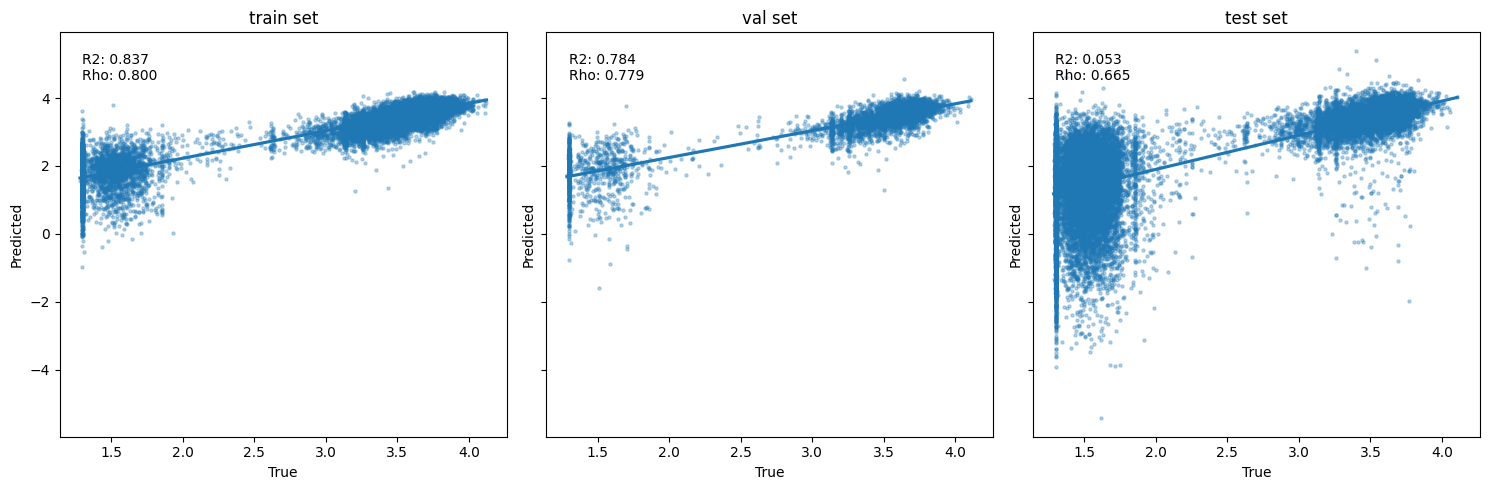

In [63]:
plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val)

## Stability

### mean

In [64]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('stability', 'mean')

Dataset statistics
Train --> X:(53614, 640), y:(53614,)
Val  --> X:(2512, 640), y:(2512,)
Test --> X:(12851, 640), y:(12851,)


In [65]:
model = run_lassoCV(X_train, y_train, X_val, y_val)
model

R2 Score: 0.501
rho Score: 0.610
Best alpha: 0.00010755411748977665
Number of non-zero coefficients: 228


LassoCV(cv=5, random_state=0)

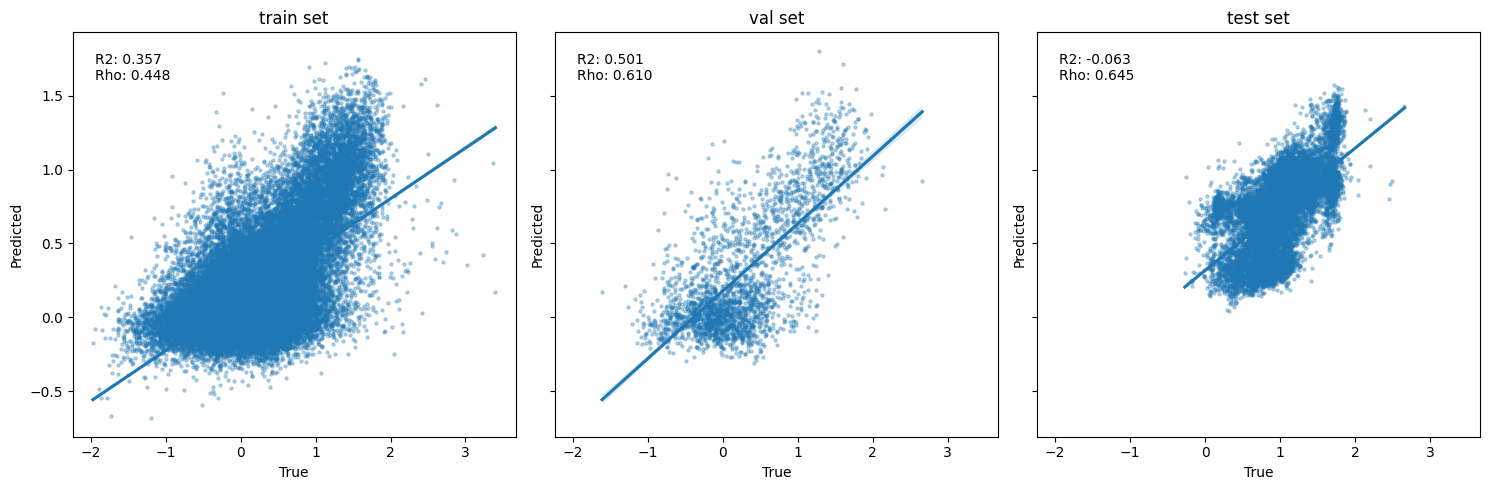

In [66]:
plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val)

### iDCT

In [67]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('stability', 'iDCT')

Dataset statistics
Train --> X:(53614, 5120), y:(53614,)
Val  --> X:(2512, 5120), y:(2512,)
Test --> X:(12851, 5120), y:(12851,)


In [68]:
model = run_lassoCV(X_train, y_train, X_val, y_val)
model

R2 Score: 0.506
rho Score: 0.613
Best alpha: 0.0003788361419969721
Number of non-zero coefficients: 1128


LassoCV(cv=5, random_state=0)

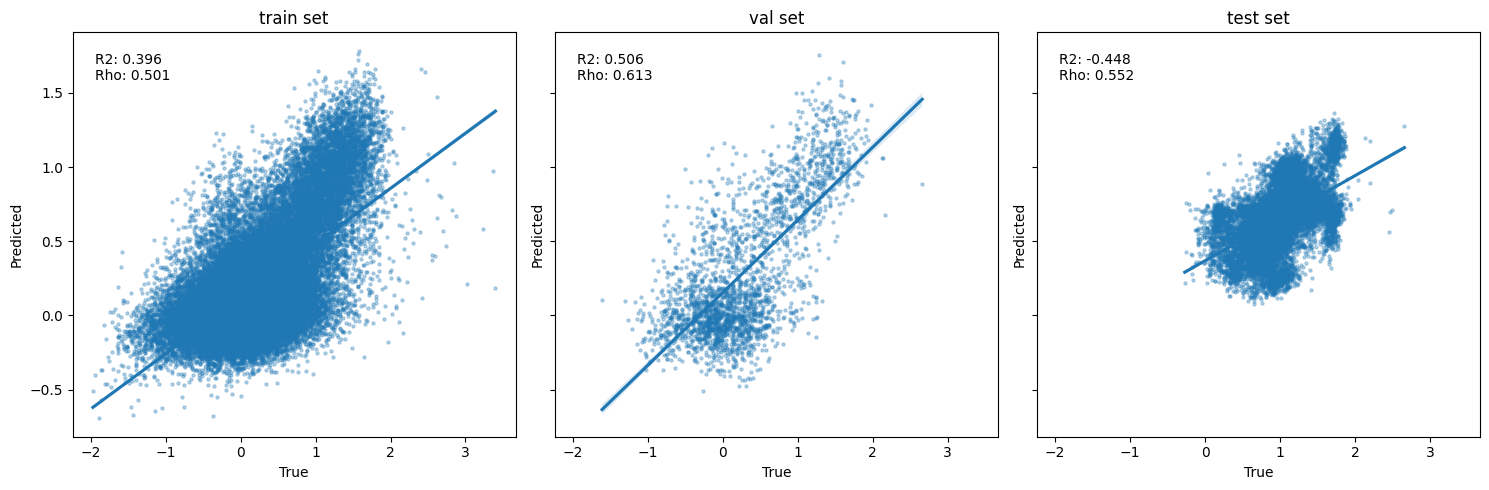

In [69]:
plot_results(model, X_train, X_test, X_val, y_train, y_test, y_val)

# Subcellular Localization 2

### mean

In [70]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('subcellular_localization_2', 'mean')

Dataset statistics
Train --> X:(5184, 640), y:(5184,)
Val  --> X:(1729, 640), y:(1729,)
Test --> X:(1749, 640), y:(1749,)


In [80]:
# Silence the ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    # Create and fit the model
    model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    accuracy = metrics.accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Best C: {model.C_}")

# Assuming X_train, y_train, X_val, and y_val are defined elsewhere in your code

Accuracy: 0.899
ROC AUC: 0.950
Best C: [0.35938137]


In [75]:
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9159519725557461

### iDCT

In [76]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('subcellular_localization_2', 'iDCT')

Dataset statistics
Train --> X:(5184, 5120), y:(5184,)
Val  --> X:(1729, 5120), y:(1729,)
Test --> X:(1749, 5120), y:(1749,)


In [77]:
# Silence the ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    # Create and fit the model
    model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    accuracy = metrics.accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Best C: {model.C_}")

# Assuming X_train, y_train, X_val, and y_val are defined elsewhere in your code

Accuracy: 0.912
ROC AUC: 0.955
Best C: [0.04641589]


In [78]:
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8925100057175529

# Subcellular Localization

In [83]:
X_train, y_train, X_test, y_test, X_val, y_val = load_data('subcellular_localization', 'mean')

Dataset statistics
Train --> X:(8420, 640), y:(8420,)
Val  --> X:(2811, 640), y:(2811,)
Test --> X:(2773, 640), y:(2773,)


In [ ]:
for i in model.classes_.astype(int):
            coefs[f'class_{i}_non_zero_coef'].append(np.sum(coefficients[i] != 0))

In [ ]:
# Silence the ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    # Create and fit the model
    model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    accuracy = metrics.accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_pred_proba, multi_class='ovr')

    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Best C: {model.C_}")


In [85]:
metrics.accuracy_score(y_val, y_pred)

0.7801494130202775